In [1]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

In [2]:
image_dir = "../custom_image_dataset_loader/Classification_dataset_v3/images/train"
for lable,class_dir in enumerate(os.listdir(image_dir)):
    print(lable,class_dir)

0 Cat
1 Dog
2 person


In [3]:
class ImageDataset(Dataset):
    def __init__(self,image_dir,transform=None):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []
        self.class_name = {}
        self.transform = transform


        for label,class_dir in enumerate(os.listdir(image_dir)):
            self.class_name[label] = class_dir
            class_path = os.path.join(image_dir,class_dir)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path,image_name))
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, idx):
        img_path =  self.image_paths[idx] 
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)


        return image,label

In [4]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
    ]
)

# mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225]


In [5]:
train_image_dir = "../custom_image_dataset_loader/Classification_dataset_v3/images/train"
test_image_dir = "../custom_image_dataset_loader/Classification_dataset_v3/images/test"
train_image_dataset = ImageDataset(image_dir=train_image_dir,transform=transform)
test_image_dataset = ImageDataset(image_dir=test_image_dir,transform=transform)

In [6]:
train_image_loader = DataLoader(dataset=train_image_dataset,batch_size=32,shuffle=True)
test_image_loader = DataLoader(dataset=test_image_dataset,batch_size=32,shuffle=True)

In [7]:
for images,labels in train_image_loader:
    print(images.shape,labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [8]:
from matplotlib import pyplot as plt
import numpy as np

In [9]:
print(train_image_dataset.class_name)
print(test_image_dataset.class_name)

{0: 'Cat', 1: 'Dog', 2: 'person'}
{0: 'Cat', 1: 'Dog', 2: 'person'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.99215686].


torch.Size([32, 3, 128, 128]) torch.Size([32])
Dog
(128, 128, 3)
1


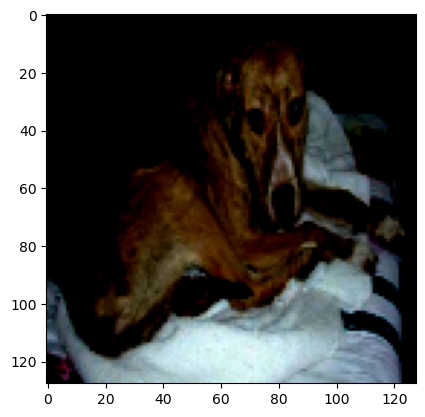

In [10]:
for images,labels in train_image_loader:
    print(images.shape,labels.shape)
    img = images[0].numpy()
    label = labels[0].item()
    print(train_image_dataset.class_name[label])
    img = np.transpose(img,(1,2,0))
    print(img.shape)
    print(label)
    plt.imshow(img,vmin=0,vmax=255)
    break

##### Custom CNN-Architecture

In [11]:
import torch.nn as nn
import torch.optim as optim

In [12]:
class CustomCnnModel(nn.Module):
    def __init__(self,input_dim,num_classes):
        super(CustomCnnModel,self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            #C1
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # 122x128x3 --> 3x3x3x32 --> wxhx32
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #C2
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #C3
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # C4
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self._to_linear = None
        self._get_conv_output(self.input_dim)


        self.fc_layer = nn.Sequential(
            nn.Linear(self._to_linear,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,self.num_classes)
        )


    def _get_conv_output(self,input_dim=128):
        with torch.no_grad():
            dummy_input = torch.zeros(1,3,input_dim,input_dim)
            output = self.conv_layers(dummy_input)
            self._to_linear = output.view(1,-1).size(1)




    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x


In [13]:
# Initialize the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=128,num_classes=3).to(device)

In [14]:
print(model)

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0011)

##### Training Loop

In [16]:
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images,labels in train_image_loader:
        images,lebels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss:{running_loss/len(train_image_loader)}")

Epoch 1/30, Loss:1.0140614123720872
Epoch 2/30, Loss:0.6362746721819827
Epoch 3/30, Loss:0.5373767626912971
Epoch 4/30, Loss:0.4925269475108699
Epoch 5/30, Loss:0.45449037222485794
Epoch 6/30, Loss:0.39917713137049426
Epoch 7/30, Loss:0.3777606942151722
Epoch 8/30, Loss:0.339556959271431
Epoch 9/30, Loss:0.3179835010516016
Epoch 10/30, Loss:0.26102498989356193
Epoch 11/30, Loss:0.24067756827724607
Epoch 12/30, Loss:0.2103620764456297
Epoch 13/30, Loss:0.2016350383037015
Epoch 14/30, Loss:0.18062598054346285
Epoch 15/30, Loss:0.14890797498979066
Epoch 16/30, Loss:0.08743530744196552
Epoch 17/30, Loss:0.10555991503459058
Epoch 18/30, Loss:0.07261930802640947
Epoch 19/30, Loss:0.07408865393984965
Epoch 20/30, Loss:0.05190398796694353
Epoch 21/30, Loss:0.09655399675432004
Epoch 22/30, Loss:0.05444171665187337
Epoch 23/30, Loss:0.08282881681684796
Epoch 24/30, Loss:0.05798238269727383
Epoch 25/30, Loss:0.026173941654729117
Epoch 26/30, Loss:0.03312043627864975
Epoch 27/30, Loss:0.0536710887

In [17]:
torch.save(model.state_dict(),"cnn_model.pth")

###### Evaluate the Model

In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images,labels in test_image_loader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct+= (predicted == labels).sum().item()

print(f"Test accuracy is {100* correct / total:.2f}%")

Test accuracy is 80.50%


In [ ]:
# !conda install -c conda-forge opencv -y  #got some issues
# !conda remove opencv -y
# !pip install opencv-python

In [ ]:
import cv2 as cv

In [ ]:
class ImageClassifier:
    def __init__(self,model_path,class_names):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = CustomCnnModel(input_dim=128,num_classes=3).to(device)
        self.model.load_state_dict(torch.load(model_path,map_location=self.device))
        self.model.eval()
        self.class_names = class_names
    
        self.transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
            ]
        )

    def predict(self,image_path):
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(input_tensor)
            _,predicted = torch.max(output,1)
            label = self.class_names[predicted.item()]
        
        img = cv.imread(image_path)
        cv.putText(img,label,(10,30),cv.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        cv.imwrite("output_image1.jpg",img)
        return label

In [ ]:
import os
classifier = ImageClassifier("cnn_model.pth",train_image_dataset.class_name)
image_path =os.path.expanduser("~/Downloads/dog.jpg") 
label = classifier.predict(image_path)
print(f"Predicted class is:",label)